In [2]:
import os 
os.chdir('/home/enmartz/Projects/hdsp/colibri-hdsp')

Demo CASSI Reconstruction

In [11]:
#General imports
import os

import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid
from tqdm import tqdm

from colibri_hdsp.archs import E2E
from colibri_hdsp.data.datasets import Dataset
from colibri_hdsp.metrics import psnr, ssim
from colibri_hdsp.models import build_network, Unet
from colibri_hdsp.optics.cassi import CASSI

# Check GPU support
print("GPU support: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU support:  True


Load Dataset

In [12]:
dataset_path = 'cifar10'
keys = ''
batch_size = 128

dataset = Dataset(dataset_path, keys, batch_size)

Loading dataset:  cifar10
Files already downloaded and verified
Files already downloaded and verified


Visualize samples

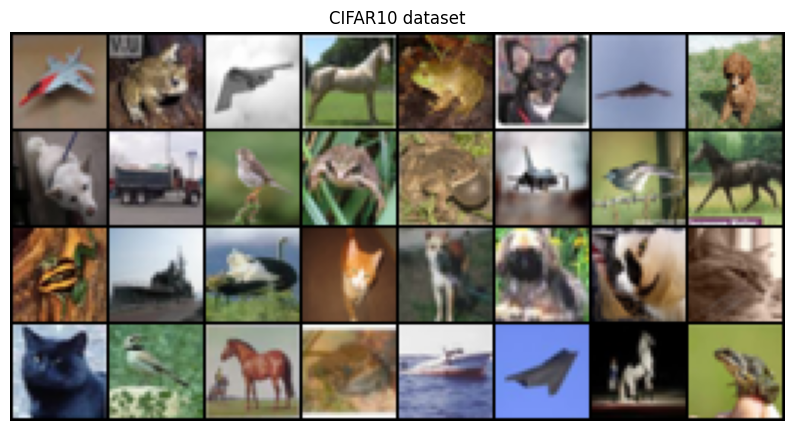

In [14]:
sample = next(iter(dataset.train_dataset))[0]
img = make_grid(sample[:32], nrow=8, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(10,10))
plt.imshow(img.permute(1, 2, 0))
plt.title('CIFAR10 dataset')
plt.axis('off')
plt.show()

Optics Layer

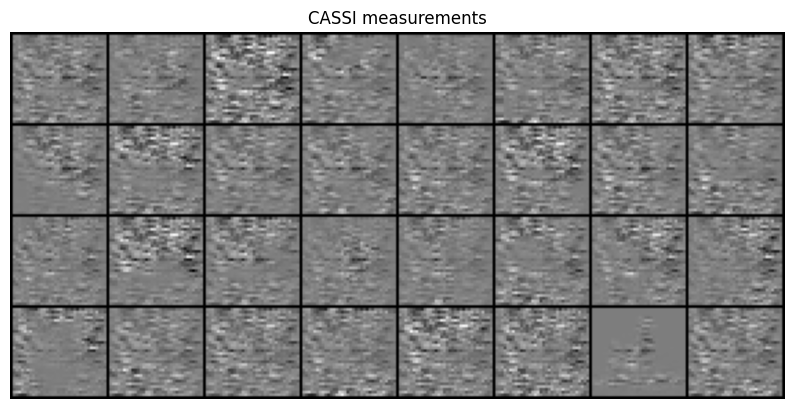

In [15]:
mode = 'base' # Type of CASSi optical system
cassi =  CASSI(sample.shape[1:], mode,  trainable=True) # CASSI layer
y = cassi(sample) # CASSI measurements

img = make_grid(y[:32], nrow=8, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)


plt.figure(figsize=(10,10))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title('CASSI measurements')
plt.show()

Model Class

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class ModelE2E:
    def __init__(self, optical_encoder, computational_decoder):
        self.optical_encoder = optical_encoder
        self.computational_decoder = computational_decoder

        self.e2e_model = E2E(self.optical_encoder, self.computational_decoder)

    def parameters(self):
        return self.e2e_model.parameters()

    def setup(self, optimizer=None, loss_fn=None, metrics=None):
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.metrics = metrics
        self.dict_metrics = {name: AverageMeter() for name in self.metrics.keys()}

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.e2e_model.to(self.device)
        self.loss_fn.to(self.device)

    def update_metrics(self, x_hat, x):
        for name, metric in self.metrics.items():
            self.dict_metrics[name].update(metric(x_hat, x).item())

    def reset_metrics(self):
        for _, metric in self.dict_metrics.items():
            metric.reset()

    def train(self, train_dataset, epochs, validation_dataset=None):
        for i in range(epochs):
            self.reset_metrics()

            # training

            self.e2e_model.train()

            # use tqdm for progress bar

            loop = tqdm(train_dataset, leave=True)
            for x, y in loop:
                self.optimizer.zero_grad()

                loss = self.forward_step(x.to(self.device), y.to(self.device))

                loss.backward()
                self.optimizer.step()

                loop.set_description(f'Train: Epoch [{i + 1}/{epochs}]')
                loop.set_postfix(loss=loss.item(),
                                 **{name: metric.avg for name, metric in self.dict_metrics.items()})

            # validation
            self.reset_metrics()

            if validation_dataset is not None:
                self.e2e_model.eval()

                loop = tqdm(validation_dataset, leave=True)
                for x, y in loop:
                    loss = self.forward_step(x.to(self.device), y.to(self.device))

                    loop.set_description(f'Validation: Epoch [{i + 1}/{epochs}]')
                    loop.set_postfix(loss=loss.item(),
                                     **{name: metric.avg for name, metric in self.dict_metrics.items()})

    def forward_step(self, x, y):
        x_hat = self.e2e_model(x)

        loss = self.loss_fn(x_hat, x)
        self.update_metrics(x_hat, x)

        return loss

Build Model

In [17]:
computational_decoder = build_network(Unet, in_channels=cassi.L, out_channels=cassi.L)
model = ModelE2E(cassi, computational_decoder)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()
metrics = dict(psnr=psnr, ssim=ssim)
model.setup(optimizer, loss_fn, metrics)

Training Loop

In [18]:
model.train(dataset.train_dataset, epochs=10, validation_dataset=dataset.test_dataset)

Validation: Epoch [10/10]: 100%|██████████| 79/79 [00:02<00:00, 30.34it/s, loss=0.00215, psnr=26.9, ssim=0.913]


Visualize results

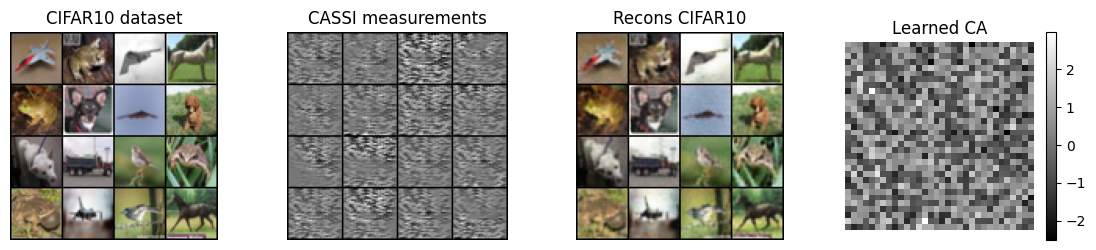

In [21]:
x_est = model.e2e_model(sample.to(device)).cpu()
y_cassi = cassi(sample.to(device)).cpu()

img      = make_grid(sample[:16], nrow=4, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)
img_est  = make_grid(x_est[:16], nrow=4, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)
img_casi = make_grid(y_cassi[:16], nrow=4, padding=1, normalize=True, range=None, scale_each=False, pad_value=0)

imgs_dict = {
    "CIFAR10 dataset": img, 
    "CASSI measurements": img_casi,
    "Recons CIFAR10": img_est
}

plt.figure(figsize=(14, 2.7))

for i, (title, img) in enumerate(imgs_dict.items()):
    plt.subplot(1, 4, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

ca = cassi.ca.cpu().detach().numpy().squeeze()

plt.subplot(1, 4, 4)
plt.imshow(ca, cmap='gray')
plt.axis('off')
plt.title('Learned CA')
plt.colorbar()

plt.show()